In [ ]:
!pip install einops
!pip install einops_exts
!pip install rotary_embedding_torch
!pip install umap
!pip install umap-learn
!pip install scanpy
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3565 sha256=b8560457aebc1f871a52d82328e1a584da279c13a07f4a4911e7db5c270b903f
  Stored in directory: /root/.cache/pip/wheels/65/55/85/945cfb3d67373767e4dc3e9629300a926edde52633df4f0efe
Successfully built umap
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.1 MB/s 
     |████████████████████████████████| 1.1 MB 24.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=d7ef42b0ab33e2aa12e9bd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 3.8 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scanpy 1.9.1 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.


In [ ]:
rootpath = ''
import pandas as pd

file = open(rootpath+'Observed_r2_distance_z.csv', 'rb')
proteins = pd.read_csv(file)['scheme'].tolist()
file = open(rootpath+'Observed_r2_distance_z.csv', 'rb')
r2s = pd.read_csv(file)['r2-PerturbNet_Sample'].tolist()

file = open(rootpath+'Observed_fid_distance_z.csv', 'rb')
proteins_train = pd.read_csv(file)['scheme'].tolist()
file = open(rootpath+'Observed_fid_distance_z.csv', 'rb')
fids = pd.read_csv(file)['fid-PerturbNet_Sample'].tolist()
file = open(rootpath+'Observed_fid_distance_z.csv', 'rb')
ns = pd.read_csv(file)['n'].tolist()
ns = [int(n) for n in ns]

In [ ]:
print(len(proteins_train))

1208


In [ ]:
rootpath = '/content/drive/My Drive/'
import pickle
with open(rootpath+'RNA.pickle', 'rb') as handle:
    dict_rna = pickle.load(handle)

with open(rootpath+'Protein.pickle', 'rb') as handle:
    dict_protein = pickle.load(handle)


import numpy as np

protein_list = []
label_list = []
def dict2array(dict_rna, dict_protein):
  i = 0
  for (j, key) in enumerate(dict_rna):
    if key in proteins_train:
      for _, item in enumerate(dict_rna[key]):
        RNA[i,:] = item
        protein[i,:] = dict_protein[key]
        weight[i,:] = len(dict_rna[key])
        protein_list.append(key)
        label_list.append(j)
        i = i + 1
  return RNA[:i], protein[:i], protein_list, weight[:i], label_list

n = sum([len(dict_rna[key]) for key in dict_rna])
rna_dim = [dict_rna[key][0].shape[0] for key in dict_rna][0]
protein_dim = [dict_protein[key].shape[0] for key in dict_protein][0]
protein = np.zeros((n, protein_dim))
RNA = np.zeros((n, rna_dim))
weight = np.zeros((n, 1))
RNA, Protein, protein_list, weight, label_list = dict2array(dict_rna, dict_protein)
print(RNA.shape, Protein.shape, weight.shape, len(protein_list))

(134222, 1629) (134222, 1280) (134222, 1) 134222


2.5527188777923584 -17.19583511352539
462.0 0.0
12436.0 1.0


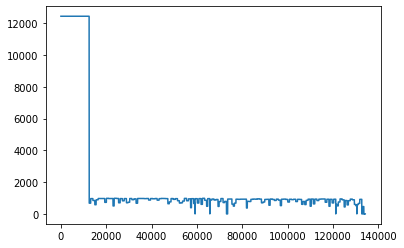

In [ ]:
print(np.max(Protein), np.min(Protein))
print(np.max(RNA), np.min(RNA))
print(weight.max(),weight.min())
import matplotlib.pyplot as plt

plt.plot(weight)

In [ ]:
print(Protein[0]-Protein[90000])

[-0.1582361  -0.12561627 -0.03671896 ... -0.03412898 -0.00158754
 -0.3226781 ]


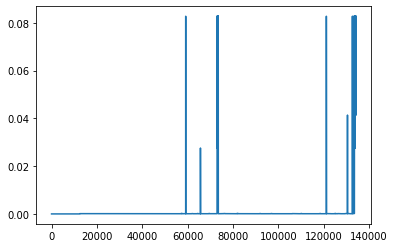

In [ ]:
num = weight.copy()
weight = weight.max()/weight
weight = weight/weight.sum()
weight = weight*100
plt.plot(weight)

In [ ]:
import scanpy
import pandas as pd

category = {}
for (i, prot) in enumerate(label_list):
    category[str(i)] = prot
adata_rna = scanpy.AnnData(RNA)
a = pd.Series(list(category), dtype='category')
adata_rna.obs['category'] = np.array(label_list).astype(np.float32)


# scanpy.tl.pca(adata_rna, svd_solver='arpack', n_comps=128)
# adata = scanpy.AnnData(adata.obsm['X_pca'])
# adata.obs['category'] = np.array(label_).astype(np.float32)

scanpy.pp.neighbors(adata_rna, n_neighbors=10, n_pcs=0)
scanpy.tl.umap(adata_rna)
scanpy.pl.umap(adata_rna, color='category')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  import sys


KeyboardInterrupt: ignored

In [ ]:
""" CLIP """

from numpy.core.fromnumeric import clip
import pandas as pd
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data as utils
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import StandardScaler


class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim,
        dropout=0.1
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

class CLIP(nn.Module):
    def __init__(self, RNA_size, protein_size, latent_size, projection_dim):
        super(CLIP, self).__init__()
        self.latent_size = latent_size

        self.encoder1 = nn.Sequential(
          nn.Linear(RNA_size, latent_size, bias=True),
          nn.BatchNorm1d(latent_size),
          nn.ReLU(),
          nn.Dropout(p=0.0),
          nn.Linear(latent_size, latent_size, bias=True),
          # nn.BatchNorm1d(latent_size),
          # nn.ReLU(),
          # nn.Dropout(p=0.0),
          # nn.Linear(latent_size, latent_size, bias=True),
        )

        self.encoder2 = nn.Sequential(
          nn.Linear(protein_size, 512, bias=True),
          nn.BatchNorm1d(512),
          nn.ReLU(),
          nn.Dropout(p=0.0),
          nn.Linear(512, latent_size, bias=True),
        )

        # self.decoder = nn.Sequential(
        #   nn.Linear(latent_size, 512, bias=True),
        #   nn.BatchNorm1d(512),
        #   nn.LeakyReLU(negative_slope=0.01),
        #   nn.Dropout(p=0.2),
        #   nn.Linear(512, 1024, bias=True),
        #   nn.BatchNorm1d(1024),
        #   nn.LeakyReLU(negative_slope=0.01),
        #   nn.Dropout(p=0.2),
        #   nn.Linear(1024, RNA_size, bias=True),
        # )

        self.protein_projection = ProjectionHead(embedding_dim=protein_size, projection_dim=projection_dim)
        self.RNA_projection = ProjectionHead(embedding_dim=latent_size, projection_dim=projection_dim)
        self.temperature = torch.nn.Parameter(torch.Tensor(1))

        # self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x, protein):
        z1 = self.encoder1(x)
        z2 = self.encoder2(protein)
        return z1, z2

    def loss_function(self, x, z, protein, weight):
        # protein_embeddings = self.protein_projection(protein)
        protein_embeddings = (protein)
        # RNA_embeddings = self.RNA_projection(z)
        RNA_embeddings = (z)
        logits = (protein_embeddings @ RNA_embeddings.T) / self.temperature
        protein_similarity = protein_embeddings @ protein_embeddings.T
        RNA_similarity = RNA_embeddings @ RNA_embeddings.T
        targets = F.softmax((RNA_similarity + protein_similarity) / 2 * self.temperature, dim=-1)
        protein_loss = cross_entropy(logits, targets, reduction='none')
        RNA_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  ((RNA_loss + protein_loss) / 2.0)
        return (loss*weight).sum()/RNA_embeddings.size(1)

def to_var(x, use_cuda):
    x = Variable(x)
    if use_cuda:
        x = x.cuda()
    return x

def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()


# logits = (perturbation_embeddings @ gene_embeddings.T) / temperature
# perturbation_similarity = perturbation_embeddings @ perturbation_embeddings.T
# gene_similarity = gene_embeddings @ gene_embeddings.T
# targets = softmax((perturbation_similarity + gene_similarity) / 2 * temperature, axis=-1)
# perturbation_loss = cross_entropy(logits, targets)
# gene_loss = cross_entropy(logits.T, targets.T)
# loss =  (perturbation_loss_loss + gene_loss_loss) / 2.0

def train_one_epoch(epoch, model, train_loader, optimizer, use_cuda):
    model.train()
    train_loss = 0
    for batch_idx, (rna, protein, w) in enumerate(train_loader):
        rna = to_var(rna, use_cuda)
        protein = to_var(protein, use_cuda)
        w = to_var(w, use_cuda)
        z1_batch, z2_batch = model(rna, protein)
        loss = model.loss_function(rna, z1_batch, protein, w)
        loss = Variable(loss, requires_grad = True)
        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.data*rna.size(0)
        optimizer.step()
    print('Epoch {}: Loss = {:.6f}'.format(
            epoch, train_loss/train_num))
    return train_loss/train_num
      
use_cuda = True
RNA_size = RNA.shape[1]
protein_size = Protein.shape[1]
train_num = RNA.shape[0]
latent_size = protein_size
projection_dim = 400
batch_size = 1024
num_epochs = 100

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_RNA, train_Protein, train_weight = torch.Tensor(RNA), torch.Tensor(Protein), torch.Tensor(weight)
train_dataset = utils.TensorDataset(train_RNA, train_Protein, train_weight)
train_loader = utils.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
  
model = CLIP(RNA_size, protein_size, latent_size, projection_dim)
# model = torch.load(rootpath+'CLIP.pt')

# def dfs_freeze(model):
#   for param in model.decoder.parameters():
#     param.requires_grad = False

# dfs_freeze(model)

# if use_cuda:
#     model.cuda()

# loss_list = []
# train_loss = 0
# for batch_idx, (rna, protein, w) in enumerate(train_loader):
#     rna = to_var(rna, use_cuda)
#     protein = to_var(protein, use_cuda)
#     w = to_var(w, use_cuda)
#     z1_batch, z2_batch = model(rna, protein)
#     loss = model.loss_function(rna, z1_batch, protein, w)
#     train_loss += loss.data*rna.size(0)
# print('Epoch {}: Loss = {:.6f}'.format(
#         0, train_loss))
# loss_list.append((train_loss/train_num).item())
# train_loss = train_loss/train_num

# optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, amsgrad=True)
# for epoch in range(1, num_epochs+1):
#     train_loss = train_one_epoch(epoch, model, train_loader, optimizer, use_cuda)
#     loss_list.append(train_loss.item())

In [ ]:
torch.save(model, rootpath+'encoder_ursu_new.pt')

In [ ]:
import torch
import sklearn

encoder = torch.load(rootpath+'encoder_ursu_new.pt')
# encoder = model
train_RNA, train_Protein, train_weight = torch.Tensor(RNA), torch.Tensor(Protein), torch.Tensor(weight)

train_RNA.to('cpu')
encoder.to('cpu')
encoder.eval()
RNA_embd, _ = encoder(train_RNA, train_Protein)
Protein_embd = train_Protein
RNA_embd_scale = torch.Tensor(sklearn.preprocessing.minmax_scale(RNA_embd.detach().numpy(), feature_range=(-10, 10), axis=0))

RNA_max = RNA_embd.max(0)[0]
RNA_min = RNA_embd.min(0)[0]

use_cuda = False
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_dataset = utils.TensorDataset(train_RNA, train_Protein, RNA_embd_scale, RNA_embd, Protein_embd, train_weight)
train_loader = utils.DataLoader(train_dataset, batch_size=1024, shuffle=True, **kwargs)
print(Protein_embd.size(), RNA_embd.size())

torch.Size([134222, 1280]) torch.Size([134222, 1280])


In [ ]:
print('RNA_embedding:')
print(RNA_embd.max(), RNA_embd.min(), torch.abs(RNA_embd).min(), torch.abs(RNA_embd).mean())
print('Protein_embedding:')
print(Protein_embd.max(), Protein_embd.min())

print(Protein_embd[0]-Protein_embd[90000])

RNA_embedding:
tensor(29.1719, grad_fn=<MaxBackward1>) tensor(-32.3340, grad_fn=<MinBackward1>) tensor(5.5879e-09, grad_fn=<MinBackward1>) tensor(0.3029, grad_fn=<MeanBackward0>)
Protein_embedding:
tensor(2.5527) tensor(-17.1958)
tensor([-0.1582, -0.1256, -0.0367,  ..., -0.0341, -0.0016, -0.3227])


In [ ]:
RNA_embd_scale

tensor([[-3.7351,  4.2663, -8.3447,  ...,  8.2406, -1.1071,  1.0090],
        [-4.3253,  4.6982, -8.4249,  ...,  7.5591, -1.1127,  1.1995],
        [-3.3987,  4.4032, -8.6378,  ...,  8.5067, -0.3697,  0.6303],
        ...,
        [-3.9692,  5.2814, -8.1886,  ...,  7.9410, -0.7145,  1.2783],
        [-1.5278,  5.1151, -8.5521,  ...,  8.7231,  0.4832, -0.3178],
        [-2.7086,  4.2329, -8.4470,  ...,  8.2621,  0.4002,  1.4629]])

In [ ]:
def unnormalize(RNA_embd_scale, RNA_max, RNA_min):
  ((RNA_embd_scale/10+1)/2)*(RNA_max-RNA_min)+RNA_min

In [ ]:
import scanpy

category = {}
for (i, prot) in enumerate(label_list):
    category[str(i)] = prot
adata_rna = scanpy.AnnData(RNA_embd.detach().numpy())
a = pd.Series(list(category), dtype='category')
adata_rna.obs['category'] = np.array(label_list).astype(np.float32)


# scanpy.tl.pca(adata_rna, svd_solver='arpack', n_comps=128)
# adata = scanpy.AnnData(adata.obsm['X_pca'])
# adata.obs['category'] = np.array(label_).astype(np.float32)

scanpy.pp.neighbors(adata_rna, n_neighbors=10, n_pcs=0)
scanpy.tl.umap(adata_rna)
scanpy.pl.umap(adata_rna, color='category')

KeyboardInterrupt: ignored

In [ ]:
import scanpy

category = {}
for (i, prot) in enumerate(label_list):
    category[str(i)] = prot
adata_protein = scanpy.AnnData(Protein_embd.detach().numpy())
a = pd.Series(list(category), dtype='category')
adata_protein.obs['category'] = np.array(label_list).astype(np.float32)


# scanpy.tl.pca(adata_rna, svd_solver='arpack', n_comps=128)
# adata = scanpy.AnnData(adata.obsm['X_pca'])
# adata.obs['category'] = np.array(label_).astype(np.float32)

scanpy.pp.neighbors(adata_protein, n_neighbors=10, n_pcs=40)
scanpy.tl.umap(adata_protein)
scanpy.pl.umap(adata_protein, color='category')

         Falling back to preprocessing with `sc.pp.pca` and default params.


KeyboardInterrupt: ignored

In [ ]:
""" diffusion model """

import math
import copy
import torch
from torch import nn, einsum
import torch.nn.functional as F
from inspect import isfunction
from functools import partial

from torch.utils import data
from torch.cuda.amp import autocast, GradScaler

from pathlib import Path
from torch.optim import Adam
from torchvision import transforms, utils
from PIL import Image

from tqdm import tqdm

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from einops_exts import rearrange_many, repeat_many, check_shape
from einops_exts.torch import EinopsToAndFrom

from numpy.core.fromnumeric import clip
import pandas as pd
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data as utils
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import StandardScaler


def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

def cycle(dl):
    while True:
        for data in dl:
            yield data

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5

def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

def linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype = torch.float64)

def cosine_beta_schedule(timesteps, s = 0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype = torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

def l2norm(t):
    return F.normalize(t, dim = -1)

class Prior(nn.Module):
    def __init__(
        self,
        denoise_fn,
        *,
        dim = 256,
        timesteps = 1000,
        loss_type = 'l1',
        objective = 'pred_noise',
        beta_schedule = 'cosine',
        scale = 1.,
        cond_drop_prob = 0.,
        clip_num_samples = 1
    ):
        super(Prior, self).__init__()

        self.RNA_size = dim
        self.latent_size = dim
        self.denoise_fn = denoise_fn
        self.objective = objective
        self.scale = scale
        self.cond_drop_prob = cond_drop_prob
        self.clip_num_samples = clip_num_samples

        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')

        alphas = 1. - betas
        alphas_cumprod = torch.cumprod(alphas, axis=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value = 1.)

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)
        self.loss_type = loss_type

        # helper function to register buffer from float64 to float32

        register_buffer = lambda name, val: self.register_buffer(name, val.to(torch.float32))

        register_buffer('betas', betas)
        register_buffer('alphas_cumprod', alphas_cumprod)
        register_buffer('alphas_cumprod_prev', alphas_cumprod_prev)

        # calculations for diffusion q(x_t | x_{t-1}) and others

        register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1. - alphas_cumprod))
        register_buffer('log_one_minus_alphas_cumprod', torch.log(1. - alphas_cumprod))
        register_buffer('sqrt_recip_alphas_cumprod', torch.sqrt(1. / alphas_cumprod))
        register_buffer('sqrt_recipm1_alphas_cumprod', torch.sqrt(1. / alphas_cumprod - 1))

        # calculations for posterior q(x_{t-1} | x_t, x_0)

        posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)

        register_buffer('posterior_variance', posterior_variance)

        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain

        register_buffer('posterior_log_variance_clipped', torch.log(posterior_variance.clamp(min =1e-20)))
        register_buffer('posterior_mean_coef1', betas * torch.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod))
        register_buffer('posterior_mean_coef2', (1. - alphas_cumprod_prev) * torch.sqrt(alphas) / (1. - alphas_cumprod))

    def predict_start_from_noise(self, x_t, t, noise):
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start +
            extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, x, c, t, cond_scale, clip_denoised, *kwargs):
        model_output = self.denoise_fn.forward_with_cond_scale(x, c, t, *kwargs)

        # cond_scale=cond_scale

        if self.objective == 'pred_noise':
            x_start = self.predict_start_from_noise(x, t = t, noise = model_output)
        elif self.objective == 'pred_x0':
            x_start = model_output
        else:
            raise ValueError(f'unknown objective {self.objective}')

        x_start.clamp_(-clip_denoised, clip_denoised)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start = x_start, x_t = x, t = t)
        return model_mean, posterior_variance, posterior_log_variance

    @torch.no_grad()
    def p_sample(self, x, c, t, cond_scale, clip_denoised, *kwargs):
        b, *_, device = *x.shape, x.device
        model_mean, _, model_log_variance = self.p_mean_variance(x, c, t, cond_scale, clip_denoised)
        noise = torch.randn_like(x)
        # no noise when t == 0
        nonzero_mask = (1 - (t == 0).float()).reshape(b, *((1,) * (len(x.shape) - 1)))
        
        return model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise

    @torch.no_grad()
    def p_sample_loop(self, c, shape, cond_scale, clip_denoised, *kwargs):
        device = self.betas.device

        b = shape[0]
        rna = torch.randn(shape[0:2], device=device)

        for i in tqdm(reversed(range(0, self.num_timesteps)), desc='sampling loop time step', total=self.num_timesteps, disable=True):
            rna = self.p_sample(rna, c, torch.full((b,), i, device=device, dtype=torch.long), cond_scale, clip_denoised)

        # rna = unnormalize_to_zero_to_one(rna)
        return rna

    @torch.no_grad()
    def sample(self, c, cond_scale=1., clip_denoised=1, *kwargs):
        # in the paper, what they did was
        # sample 2 image embeddings, choose the top 1 similarity, as judged by CLIP
        num_samples_per_batch = self.clip_num_samples
        c = repeat(c, 'b ... -> (b r) ...', r = num_samples_per_batch)

        batch_size = c.size(0)

        RNA_size = self.RNA_size
        latent_size = self.latent_size

        RNA = self.p_sample_loop(c, (batch_size, RNA_size, latent_size), cond_scale, clip_denoised)

        c = rearrange(c, '(b r) d -> b r d', r = num_samples_per_batch)
        RNA = rearrange(RNA, '(b r) d -> b r d', r = num_samples_per_batch)

        RNA /= self.scale

        sims = einsum('b r d, b r d -> b r', l2norm(c), l2norm(RNA))
        top_sim_indices = sims.topk(k = 1).indices

        top_sim_indices = repeat(top_sim_indices, 'b 1 -> b 1 d', d = RNA_size)

        top_RNA_embeds = RNA.gather(1, top_sim_indices)
        return rearrange(top_RNA_embeds, 'b 1 d -> b d')

    @torch.no_grad()
    def interpolate(self, x1, x2, t = None, lam = 0.5):
        b, *_, device = *x1.shape, x1.device
        t = default(t, self.num_timesteps - 1)

        assert x1.shape == x2.shape

        t_batched = torch.stack([torch.tensor(t, device=device)] * b)
        xt1, xt2 = map(lambda x: self.q_sample(x, t=t_batched), (x1, x2))

        rna = (1 - lam) * xt1 + lam * xt2
        for i in tqdm(reversed(range(0, t)), desc='interpolation sample time step', total=t):
            rna = self.p_sample(rna, torch.full((b,), i, device=device, dtype=torch.long))

        return rna

    def q_sample(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )

    def loss_fn(self, input, target, weight):
      if self.loss_type == 'l2':
          pct_var = (input-target)**2 
      elif self.loss_type == 'l1':
          pct_var = torch.abs(input-target)
      else:
          raise ValueError(f'invalid loss type {self.loss_type}')
      loss = pct_var * weight.expand_as(target)
      return loss.sum()

    def p_losses(self, x_start, c, t, weight, noise = None, *kwargs):
        noise = default(noise, lambda: torch.randn_like(x_start))

        x = self.q_sample(x_start=x_start, t=t, noise=noise)

        model_out = self.denoise_fn(x, c, t, *kwargs)

        # cond_drop_prob=self.cond_drop_prob

        if self.objective == 'pred_noise':
            target = noise
        elif self.objective == 'pred_x0':
            target = x_start
        else:
            raise ValueError(f'unknown objective {self.objective}')

        loss = self.loss_fn(model_out, target, weight)
        return loss

    def forward(self, rna, c, weight, *kwargs):
        (b, RNA_size), device = rna.shape, rna.device
   
        t = torch.randint(0, self.num_timesteps, (b,), device=device).long()

        rna *= self.scale

        # rna = normalize_to_neg_one_to_one(rna)
        return self.p_losses(rna, c, t, weight, *kwargs)

In [ ]:
""" denoising network """

from rotary_embedding_torch import RotaryEmbedding

def prob_mask_like(shape, prob, device):
    if prob == 1:
        return torch.ones(shape, device = device, dtype = torch.bool)
    elif prob == 0:
        return torch.zeros(shape, device = device, dtype = torch.bool)
    else:
        return torch.zeros(shape, device = device).float().uniform_(0, 1) < prob

class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(dim))
        self.register_buffer("beta", torch.zeros(dim))

    def forward(self, x):
        return F.layer_norm(x, x.shape[-1:], self.gamma, self.beta)

class MLP(nn.Module):
    def __init__(
        self,
        dim_in,
        dim_out,
        *,
        expansion_factor = 2.,
        depth = 2,
        norm = False,
    ):
        super().__init__()
        hidden_dim = int(expansion_factor * dim_out)
        norm_fn = lambda: nn.LayerNorm(hidden_dim) if norm else nn.Identity()

        layers = [nn.Sequential(
            nn.Linear(dim_in, hidden_dim),
            nn.SiLU(),
            norm_fn()
        )]

        for _ in range(depth - 1):
            layers.append(nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.SiLU(),
                norm_fn()
            ))

        layers.append(nn.Linear(hidden_dim, dim_out))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x.float())

class RelPosBias(nn.Module):
    def __init__(
        self,
        heads = 8,
        num_buckets = 32,
        max_distance = 128,
    ):
        super().__init__()
        self.num_buckets = num_buckets
        self.max_distance = max_distance
        self.relative_attention_bias = nn.Embedding(num_buckets, heads)

    @staticmethod
    def _relative_position_bucket(
        relative_position,
        num_buckets = 32,
        max_distance = 128
    ):
        n = -relative_position
        n = torch.max(n, torch.zeros_like(n))

        max_exact = num_buckets // 2
        is_small = n < max_exact

        val_if_large = max_exact + (torch.log(n.float() / max_exact) / math.log(max_distance / max_exact) * (num_buckets - max_exact)).long()
        val_if_large = torch.min(val_if_large, torch.full_like(val_if_large, num_buckets - 1))
        return torch.where(is_small, n, val_if_large)

    def forward(self, i, j, *, device):
        q_pos = torch.arange(i, dtype = torch.long, device = device)
        k_pos = torch.arange(j, dtype = torch.long, device = device)
        rel_pos = rearrange(k_pos, 'j -> 1 j') - rearrange(q_pos, 'i -> i 1')
        rp_bucket = self._relative_position_bucket(rel_pos, num_buckets = self.num_buckets, max_distance = self.max_distance)
        values = self.relative_attention_bias(rp_bucket)
        return rearrange(values, 'i j h -> h i j')

class SwiGLU(nn.Module):
    """ used successfully in https://arxiv.org/abs/2204.0231 """
    def forward(self, x):
        x, gate = x.chunk(2, dim = -1)
        return x * F.silu(gate)

def FeedForward(
    dim,
    mult = 4,
    dropout = 0.,
    post_activation_norm = False
):
    """ post-activation norm https://arxiv.org/abs/2110.09456 """

    inner_dim = int(mult * dim)
    return nn.Sequential(
        LayerNorm(dim),
        nn.Linear(dim, inner_dim * 2, bias = False),
        SwiGLU(),
        LayerNorm(inner_dim) if post_activation_norm else nn.Identity(),
        nn.Dropout(dropout),
        nn.Linear(inner_dim, dim, bias = False)
    )

# attention

class Attention(nn.Module):
    def __init__(
        self,
        dim,
        *,
        dim_head = 64,
        heads = 8,
        dropout = 0.,
        causal = False,
        rotary_emb = None
    ):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        inner_dim = dim_head * heads

        self.causal = causal
        self.norm = LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

        self.null_kv = nn.Parameter(torch.randn(2, dim_head))
        self.to_q = nn.Linear(dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(dim, dim_head * 2, bias = False)

        self.rotary_emb = rotary_emb

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim, bias = False),
            LayerNorm(dim)
        )

    def forward(self, x, mask = None, attn_bias = None):
        b, n, device = *x.shape[:2], x.device

        x = self.norm(x)
        q, k, v = (self.to_q(x), *self.to_kv(x).chunk(2, dim = -1))

        q = rearrange(q, 'b n (h d) -> b h n d', h = self.heads)
        q = q * self.scale

        # rotary embeddings

        if exists(self.rotary_emb):
            q, k = map(self.rotary_emb.rotate_queries_or_keys, (q, k))

        # add null key / value for classifier free guidance in prior net

        nk, nv = repeat_many(self.null_kv.unbind(dim = -2), 'd -> b 1 d', b = b)
        k = torch.cat((nk, k), dim = -2)
        v = torch.cat((nv, v), dim = -2)

        # calculate query / key similarities

        sim = einsum('b h i d, b j d -> b h i j', q, k)

        # relative positional encoding (T5 style)

        if exists(attn_bias):
            sim = sim + attn_bias

        # masking

        max_neg_value = -torch.finfo(sim.dtype).max

        if exists(mask):
            mask = F.pad(mask, (1, 0), value = True)
            mask = rearrange(mask, 'b j -> b 1 1 j')
            sim = sim.masked_fill(~mask, max_neg_value)

        if self.causal:
            i, j = sim.shape[-2:]
            causal_mask = torch.ones((i, j), dtype = torch.bool, device = device).triu(j - i + 1)
            sim = sim.masked_fill(causal_mask, max_neg_value)

        # attention

        sim = sim - sim.amax(dim = -1, keepdim = True).detach()
        attn = sim.softmax(dim = -1)
        attn = self.dropout(attn)

        # aggregate values

        out = einsum('b h i j, b j d -> b h i d', attn, v)

        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class CausalTransformer(nn.Module):
    def __init__(
        self,
        *,
        dim,
        depth = 4,
        dim_head = 64,
        heads = 12,
        ff_mult = 4,
        norm_out = True,
        attn_dropout = 0.,
        ff_dropout = 0.,
        final_proj = True,
        normformer = False,
        rotary_emb = True
    ):
        super().__init__()
        self.rel_pos_bias = RelPosBias(heads = heads)

        rotary_emb = RotaryEmbedding(dim = min(32, dim_head)) if rotary_emb else None

        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim = dim, causal = True, dim_head = dim_head, heads = heads, dropout = attn_dropout, rotary_emb = rotary_emb),
                FeedForward(dim = dim, mult = ff_mult, dropout = ff_dropout, post_activation_norm = normformer)
            ]))

        self.norm = LayerNorm(dim) if norm_out else nn.Identity()  # unclear in paper whether they projected after the classic layer norm for the final denoised image embedding, or just had the transformer output it directly: plan on offering both options
        self.project_out = nn.Linear(dim, dim, bias = False) if final_proj else nn.Identity()

    def forward(
        self,
        x,
        mask = None    # we will need a mask here, due to variable length of the text encodings - also offer dalle1 strategy with padding token embeddings
    ):
        n, device = x.shape[1], x.device

        attn_bias = self.rel_pos_bias(n, n + 1, device = device)

        for attn, ff in self.layers:
            x = attn(x, mask = mask, attn_bias = attn_bias) + x
            x = ff(x) + x

        out = self.norm(x)
        return self.project_out(out)

class PriorNet(nn.Module):
    def __init__(
        self,
        dim = 256,
        num_timesteps = 1000,
        num_time_embeds = 2,
        num_image_embeds = 2,
        num_text_embeds = 2,
        **kwargs
    ):
        super().__init__()
        self.num_time_embeds = num_time_embeds
        self.num_image_embeds = num_image_embeds
        self.num_text_embeds = num_text_embeds

        self.to_text_embeds = nn.Sequential(
            nn.Linear(dim, dim * num_text_embeds) if num_text_embeds > 1 else nn.Identity(),
            Rearrange('b (n d) -> b n d', n = num_text_embeds)
        )

        self.to_time_embeds = nn.Sequential(
            nn.Embedding(num_timesteps, dim * num_time_embeds) if exists(num_timesteps) else nn.Sequential(SinusoidalPosEmb(dim), MLP(dim, dim * num_time_embeds)), # also offer a continuous version of timestep embeddings, with a 2 layer MLP
            Rearrange('b (n d) -> b n d', n = num_time_embeds)
        )

        self.to_image_embeds = nn.Sequential(
            nn.Linear(dim, dim * num_image_embeds) if num_image_embeds > 1 else nn.Identity(),
            Rearrange('b (n d) -> b n d', n = num_image_embeds)
        )

        self.learned_query = nn.Parameter(torch.randn(dim))
        self.causal_transformer = CausalTransformer(dim = dim, **kwargs)

    def forward_with_cond_scale(
        self,
        *args,
        cond_scale = 1.,
        **kwargs
    ):
        logits = self.forward(*args, **kwargs)

        if cond_scale == 1:
            return logits

        null_logits = self.forward(*args, cond_drop_prob = 1., **kwargs)
        return null_logits + (logits - null_logits) * cond_scale

    def forward(
        self,
        image_embed,
        text_embed,
        diffusion_timesteps,
        cond_drop_prob = 0.,
        text_encodings = None,
        mask = None,
    ):

        batch, dim, device, dtype = *image_embed.shape, image_embed.device, image_embed.dtype

        num_time_embeds, num_image_embeds, num_text_embeds = self.num_time_embeds, self.num_image_embeds, self.num_text_embeds

        # in section 2.2, last paragraph
        # "... consisting of encoded text, CLIP text embedding, diffusion timestep embedding, noised CLIP image embedding, final embedding for prediction"

        text_embed = self.to_text_embeds(text_embed)
        image_embed = self.to_image_embeds(image_embed)

        # make text encodings optional
        # although the paper seems to suggest it is present <--

        if not exists(text_encodings):
            text_encodings = torch.empty((batch, 0, dim), device = device, dtype = dtype)

        if not exists(mask):
            mask = torch.ones((batch, text_encodings.shape[-2]), device = device, dtype = torch.bool)

        # classifier free guidance

        keep_mask = prob_mask_like((batch,), 1 - cond_drop_prob, device = device)
        keep_mask = rearrange(keep_mask, 'b -> b 1')

        mask &= keep_mask

        # whether text embedding is masked or not depends on the classifier free guidance conditional masking

        keep_mask = repeat(keep_mask, 'b 1 -> b n', n = num_text_embeds)
        mask = torch.cat((mask, keep_mask), dim = 1)

        # whether text embedding is used for conditioning depends on whether text encodings are available for attention (for classifier free guidance, even though it seems from the paper it was not used in the prior ddpm, as the objective is different)
        # but let's just do it right

        if exists(mask):
            attend_padding = 1 + num_time_embeds + num_image_embeds # 1 for learned queries + number of image embeds + time embeds
            mask = F.pad(mask, (0, attend_padding), value = True) # extend mask for text embedding, noised image embedding, time step embedding, and learned query

        time_embed = self.to_time_embeds(diffusion_timesteps)

        learned_queries = repeat(self.learned_query, 'd -> b 1 d', b = batch)

        tokens = torch.cat((
            text_encodings,
            text_embed,
            time_embed,
            image_embed,
            learned_queries
        ), dim = -2)

        # attend

        tokens = self.causal_transformer(tokens, mask = mask)

        # get learned query, which should predict the image embedding (per DDPM timestep)

        pred_image_embed = tokens[..., -1, :]

        return pred_image_embed

In [ ]:
# RNA, Protein, RNA_embd_scale, RNA_embd, Protein_embd, weight

def to_var(x, use_cuda):
    x = Variable(x)
    if use_cuda:
        x = x.cuda()
    return x

denoise_fn = PriorNet(dim=1280, depth=1)
prior = Prior(dim=1280, denoise_fn = denoise_fn, timesteps = 1000, loss_type = 'l2', objective = 'pred_x0')
prior.load_state_dict(torch.load(rootpath+'prior_ursu_n1.pt'))
prior.to('cuda')

optimizer = optim.Adam(filter(lambda p: p.requires_grad, prior.parameters()), lr=1e-4, amsgrad=True)
for epoch in range(100):
  train_loss = 0
  for i, (_, _, x, _, c, w) in enumerate(train_loader):
    x = to_var(x, True)
    c = to_var(c, True)
    w = to_var(w*0+1, True)
    loss = prior(x, c, w)
    train_loss += loss.data

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss = train_loss/134222
  if epoch == 0:
    train_loss_min = train_loss
  if train_loss < train_loss_min:
    torch.save(prior.state_dict(), rootpath+'prior_ursu_n1.pt')
    train_loss_min = train_loss
  print('Epoch {}: Loss = {:.6f}'.format(
              epoch+1, train_loss))

Epoch 1: Loss = 289.397858
Epoch 2: Loss = 225.333893
Epoch 3: Loss = 219.367630
Epoch 4: Loss = 211.646713
Epoch 5: Loss = 210.564926
Epoch 6: Loss = 209.311234
Epoch 7: Loss = 209.610687
Epoch 8: Loss = 208.201385
Epoch 9: Loss = 207.067505
Epoch 10: Loss = 207.856567
Epoch 11: Loss = 206.830688
Epoch 12: Loss = 206.585449
Epoch 13: Loss = 205.810562
Epoch 14: Loss = 205.763077
Epoch 15: Loss = 205.110458
Epoch 16: Loss = 205.042297


KeyboardInterrupt: ignored

In [ ]:
for epoch in range(3):
  for i, (_, _, x, c, w) in enumerate(train_loader):
    b = x.size(0)
    x = to_var(x, True)
    xt = prior.q_sample(x_start=x, t=(torch.ones((b,), device='cuda')*999).to(dtype=torch.int64))
    if epoch == 0 and i == 0:
      X = xt
    else:
      X = torch.cat((X, xt))

In [ ]:
print(X.size())

torch.Size([477093, 1280])


In [ ]:
torch.std_mean(X, dim=0)

(tensor([1.0007, 0.9997, 1.0001,  ..., 0.9986, 0.9988, 0.9998], device='cuda:0'),
 tensor([ 0.0017,  0.0013,  0.0025,  ...,  0.0017,  0.0007, -0.0030],
        device='cuda:0'))

In [ ]:
""" likelihood estimation """

import numpy as np
import torch
import torch.nn.functional as F
from torch import logsumexp
from torch.distributions import Normal, Beta


def compute_elbo(vae, posterior, **kwargs):
    """ Computes the ELBO.
    The ELBO is the reconstruction error + the KL divergences
    between the variational distributions and the priors.
    It differs from the marginal log likelihood.
    Specifically, it is a lower bound on the marginal log likelihood
    plus a term that is constant with respect to the variational distribution.
    It still gives good insights on the modeling of the data, and is fast to compute.
    """
    # Iterate once over the posterior and compute the elbo
    elbo = 0
    for i_batch, tensors in enumerate(posterior):
        sample_batch, local_l_mean, local_l_var, batch_index, labels = tensors[
            :5
        ]  # general fish case
        # kl_divergence_global (scalar) should be common across all batches after training
        reconst_loss, kl_divergence, kl_divergence_global = vae(
            sample_batch,
            local_l_mean,
            local_l_var,
            batch_index=batch_index,
            y=labels,
            **kwargs
        )
        elbo += torch.sum(reconst_loss + kl_divergence).item()
    n_samples = len(posterior.indices)
    elbo += kl_divergence_global
    return elbo / n_samples


def compute_reconstruction_error(vae, posterior, **kwargs):
    """ Computes log p(x/z), which is the reconstruction error.
    Differs from the marginal log likelihood, but still gives good
    insights on the modeling of the data, and is fast to compute.
    """
    # Iterate once over the posterior and computes the reconstruction error
    log_lkl = 0
    for i_batch, tensors in enumerate(posterior):
        sample_batch, local_l_mean, local_l_var, batch_index, labels = tensors[
            :5
        ]  # general fish case

        # Distribution parameters
        outputs = vae.inference(sample_batch, batch_index, labels, **kwargs)
        px_r = outputs["px_r"]
        px_rate = outputs["px_rate"]
        px_dropout = outputs["px_dropout"]
        bernoulli_params = outputs.get("bernoulli_params", None)

        # Reconstruction loss
        reconst_loss = vae.get_reconstruction_loss(
            sample_batch,
            px_rate,
            px_r,
            px_dropout,
            bernoulli_params=bernoulli_params,
            **kwargs
        )

        log_lkl += torch.sum(reconst_loss).item()
    n_samples = len(posterior.indices)
    return log_lkl / n_samples


def compute_marginal_log_likelihood_scvi(vae, posterior, n_samples_mc=100):
    """ Computes a biased estimator for log p(x), which is the marginal log likelihood.
    Despite its bias, the estimator still converges to the real value
    of log p(x) when n_samples_mc (for Monte Carlo) goes to infinity
    (a fairly high value like 100 should be enough)
    Due to the Monte Carlo sampling, this method is not as computationally efficient
    as computing only the reconstruction loss
    """
    if vae.latent_distribution == "ln":
        raise NotImplementedError

    # Uses MC sampling to compute a tighter lower bound on log p(x)
    log_lkl = 0
    for i_batch, tensors in enumerate(posterior):
        sample_batch, local_l_mean, local_l_var, batch_index, labels = tensors
        to_sum = torch.zeros(sample_batch.size()[0], n_samples_mc)

        for i in range(n_samples_mc):

            # Distribution parameters and sampled variables
            outputs = vae.inference(sample_batch, batch_index, labels)
            px_r = outputs["px_r"]
            px_rate = outputs["px_rate"]
            px_dropout = outputs["px_dropout"]
            qz_m = outputs["qz_m"]
            qz_v = outputs["qz_v"]
            z = outputs["z"]
            ql_m = outputs["ql_m"]
            ql_v = outputs["ql_v"]
            library = outputs["library"]

            # Reconstruction Loss
            reconst_loss = vae.get_reconstruction_loss(
                sample_batch, px_rate, px_r, px_dropout
            )

            # Log-probabilities
            p_l = Normal(local_l_mean, local_l_var.sqrt()).log_prob(library).sum(dim=-1)
            p_z = (
                Normal(torch.zeros_like(qz_m), torch.ones_like(qz_v))
                .log_prob(z)
                .sum(dim=-1)
            )
            p_x_zl = -reconst_loss
            q_z_x = Normal(qz_m, qz_v.sqrt()).log_prob(z).sum(dim=-1)
            q_l_x = Normal(ql_m, ql_v.sqrt()).log_prob(library).sum(dim=-1)

            to_sum[:, i] = p_z + p_l + p_x_zl - q_z_x - q_l_x

        batch_log_lkl = logsumexp(to_sum, dim=-1) - np.log(n_samples_mc)
        log_lkl += torch.sum(batch_log_lkl).item()

    n_samples = len(posterior.indices)
    # The minus sign is there because we actually look at the negative log likelihood
    return -log_lkl / n_samples


def compute_marginal_log_likelihood_autozi(autozivae, posterior, n_samples_mc=100):
    """ Computes a biased estimator for log p(x), which is the marginal log likelihood.
    Despite its bias, the estimator still converges to the real value
    of log p(x) when n_samples_mc (for Monte Carlo) goes to infinity
    (a fairly high value like 100 should be enough)
    Due to the Monte Carlo sampling, this method is not as computationally efficient
    as computing only the reconstruction loss
    """
    # Uses MC sampling to compute a tighter lower bound on log p(x)
    log_lkl = 0
    to_sum = torch.zeros((n_samples_mc,))
    alphas_betas = autozivae.get_alphas_betas(as_numpy=False)
    alpha_prior = alphas_betas["alpha_prior"]
    alpha_posterior = alphas_betas["alpha_posterior"]
    beta_prior = alphas_betas["beta_prior"]
    beta_posterior = alphas_betas["beta_posterior"]

    for i in range(n_samples_mc):

        bernoulli_params = autozivae.sample_from_beta_distribution(
            alpha_posterior, beta_posterior
        )

        for i_batch, tensors in enumerate(posterior):
            sample_batch, local_l_mean, local_l_var, batch_index, labels = tensors

            # Distribution parameters and sampled variables
            outputs = autozivae.inference(sample_batch, batch_index, labels)
            px_r = outputs["px_r"]
            px_rate = outputs["px_rate"]
            px_dropout = outputs["px_dropout"]
            qz_m = outputs["qz_m"]
            qz_v = outputs["qz_v"]
            z = outputs["z"]
            ql_m = outputs["ql_m"]
            ql_v = outputs["ql_v"]
            library = outputs["library"]

            # Reconstruction Loss
            bernoulli_params_batch = autozivae.reshape_bernoulli(
                bernoulli_params, batch_index, labels
            )
            reconst_loss = autozivae.get_reconstruction_loss(
                sample_batch, px_rate, px_r, px_dropout, bernoulli_params_batch
            )

            # Log-probabilities
            p_l = Normal(local_l_mean, local_l_var.sqrt()).log_prob(library).sum(dim=-1)
            p_z = (
                Normal(torch.zeros_like(qz_m), torch.ones_like(qz_v))
                .log_prob(z)
                .sum(dim=-1)
            )
            p_x_zld = -reconst_loss
            q_z_x = Normal(qz_m, qz_v.sqrt()).log_prob(z).sum(dim=-1)
            q_l_x = Normal(ql_m, ql_v.sqrt()).log_prob(library).sum(dim=-1)

            batch_log_lkl = torch.sum(p_x_zld + p_l + p_z - q_z_x - q_l_x, dim=0)
            to_sum[i] += batch_log_lkl

        p_d = Beta(alpha_prior, beta_prior).log_prob(bernoulli_params).sum()
        q_d = Beta(alpha_posterior, beta_posterior).log_prob(bernoulli_params).sum()

        to_sum[i] += p_d - q_d

    log_lkl = logsumexp(to_sum, dim=-1).item() - np.log(n_samples_mc)
    n_samples = len(posterior.indices)
    # The minus sign is there because we actually look at the negative log likelihood
    return -log_lkl / n_samples


def log_zinb_positive(x, mu, theta, pi, eps=1e-8):
    """
    Note: All inputs are torch Tensors
    log likelihood (scalar) of a minibatch according to a zinb model.
    Notes:
    We parametrize the bernoulli using the logits, hence the softplus functions appearing
    Variables:
    mu: mean of the negative binomial (has to be positive support) (shape: minibatch x genes)
    theta: inverse dispersion parameter (has to be positive support) (shape: minibatch x genes)
    pi: logit of the dropout parameter (real support) (shape: minibatch x genes)
    eps: numerical stability constant
    """

    # theta is the dispersion rate. If .ndimension() == 1, it is shared for all cells (regardless of batch or labels)
    if theta.ndimension() == 1:
        theta = theta.view(
            1, theta.size(0)
        )  # In this case, we reshape theta for broadcasting

    softplus_pi = F.softplus(-pi)  #  uses log(sigmoid(x)) = -softplus(-x)
    log_theta_eps = torch.log(theta + eps)
    log_theta_mu_eps = torch.log(theta + mu + eps)
    pi_theta_log = -pi + theta * (log_theta_eps - log_theta_mu_eps)

    case_zero = F.softplus(pi_theta_log) - softplus_pi
    mul_case_zero = torch.mul((x < eps).type(torch.float32), case_zero)

    case_non_zero = (
        -softplus_pi
        + pi_theta_log
        + x * (torch.log(mu + eps) - log_theta_mu_eps)
        + torch.lgamma(x + theta)
        - torch.lgamma(theta)
        - torch.lgamma(x + 1)
    )
    mul_case_non_zero = torch.mul((x > eps).type(torch.float32), case_non_zero)

    res = mul_case_zero + mul_case_non_zero

    return res


def log_nb_positive(x, mu, theta, eps=1e-8):
    """
    Note: All inputs should be torch Tensors
    log likelihood (scalar) of a minibatch according to a nb model.
    Variables:
    mu: mean of the negative binomial (has to be positive support) (shape: minibatch x genes)
    theta: inverse dispersion parameter (has to be positive support) (shape: minibatch x genes)
    eps: numerical stability constant
    """
    if theta.ndimension() == 1:
        theta = theta.view(
            1, theta.size(0)
        )  # In this case, we reshape theta for broadcasting

    log_theta_mu_eps = torch.log(theta + mu + eps)

    res = (
        theta * (torch.log(theta + eps) - log_theta_mu_eps)
        + x * (torch.log(mu + eps) - log_theta_mu_eps)
        + torch.lgamma(x + theta)
        - torch.lgamma(theta)
        - torch.lgamma(x + 1)
    )

    return res


def log_mixture_nb(x, mu_1, mu_2, theta_1, theta_2, pi, eps=1e-8):
    """
    Note: All inputs should be torch Tensors
    log likelihood (scalar) of a minibatch according to a mixture nb model.
    pi is the probability to be in the first component.
    For totalVI, the first component should be background.
    Variables:
    mu1: mean of the first negative binomial component (has to be positive support) (shape: minibatch x genes)
    theta1: first inverse dispersion parameter (has to be positive support) (shape: minibatch x genes)
    mu2: mean of the second negative binomial (has to be positive support) (shape: minibatch x genes)
    theta2: second inverse dispersion parameter (has to be positive support) (shape: minibatch x genes)
        If None, assume one shared inverse dispersion parameter.
    eps: numerical stability constant
    """
    if theta_2 is not None:
        log_nb_1 = log_nb_positive(x, mu_1, theta_1)
        log_nb_2 = log_nb_positive(x, mu_2, theta_2)
    # this is intended to reduce repeated computations
    else:
        theta = theta_1
        if theta.ndimension() == 1:
            theta = theta.view(
                1, theta.size(0)
            )  # In this case, we reshape theta for broadcasting

        log_theta_mu_1_eps = torch.log(theta + mu_1 + eps)
        log_theta_mu_2_eps = torch.log(theta + mu_2 + eps)
        lgamma_x_theta = torch.lgamma(x + theta)
        lgamma_theta = torch.lgamma(theta)
        lgamma_x_plus_1 = torch.lgamma(x + 1)

        log_nb_1 = (
            theta * (torch.log(theta + eps) - log_theta_mu_1_eps)
            + x * (torch.log(mu_1 + eps) - log_theta_mu_1_eps)
            + lgamma_x_theta
            - lgamma_theta
            - lgamma_x_plus_1
        )
        log_nb_2 = (
            theta * (torch.log(theta + eps) - log_theta_mu_2_eps)
            + x * (torch.log(mu_2 + eps) - log_theta_mu_2_eps)
            + lgamma_x_theta
            - lgamma_theta
            - lgamma_x_plus_1
        )

    logsumexp = torch.logsumexp(torch.stack((log_nb_1, log_nb_2 - pi)), dim=0)
    softplus_pi = F.softplus(-pi)

    log_mixture_nb = logsumexp - softplus_pi

    return log_mixture_nb

In [ ]:
""" distributions """

from typing import Union, Tuple
import warnings

import torch
from torch.distributions import (
    constraints,
    Distribution,
    Gamma,
    Poisson,
)
from torch.distributions.utils import (
    broadcast_all,
    probs_to_logits,
    lazy_property,
    logits_to_probs,
)


def _convert_mean_disp_to_counts_logits(mu, theta, eps=1e-6):
    r"""NB parameterizations conversion
        :param mu: mean of the NB distribution.
        :param theta: inverse overdispersion.
        :param eps: constant used for numerical log stability.
        :return: the number of failures until the experiment is stopped
            and the success probability.
    """
    assert (mu is None) == (
        theta is None
    ), "If using the mu/theta NB parameterization, both parameters must be specified"
    logits = (mu + eps).log() - (theta + eps).log()
    total_count = theta
    return total_count, logits


def _convert_counts_logits_to_mean_disp(total_count, logits):
    """NB parameterizations conversion
        :param total_count: Number of failures until the experiment is stopped.
        :param logits: success logits.
        :return: the mean and inverse overdispersion of the NB distribution.
    """
    theta = total_count
    mu = logits.exp() * theta
    return mu, theta


class NegativeBinomial(Distribution):
    r"""Negative Binomial(NB) distribution using two parameterizations:
    - (`total_count`, `probs`) where `total_count` is the number of failures
        until the experiment is stopped
        and `probs` the success probability.
    - The (`mu`, `theta`) parameterization is the one used by scVI. These parameters respectively
    control the mean and overdispersion of the distribution.
    `_convert_mean_disp_to_counts_logits` and `_convert_counts_logits_to_mean_disp` provide ways to convert
    one parameterization to another.
    """
    arg_constraints = {
        "mu": constraints.greater_than_eq(0),
        "theta": constraints.greater_than_eq(0),
    }
    support = constraints.nonnegative_integer

    def __init__(
        self,
        total_count: torch.Tensor = None,
        probs: torch.Tensor = None,
        logits: torch.Tensor = None,
        mu: torch.Tensor = None,
        theta: torch.Tensor = None,
        validate_args=True,
    ):
        self._eps = 1e-8
        if (mu is None) == (total_count is None):
            raise ValueError(
                "Please use one of the two possible parameterizations. Refer to the documentation for more information."
            )

        using_param_1 = total_count is not None and (
            logits is not None or probs is not None
        )
        if using_param_1:
            logits = logits if logits is not None else probs_to_logits(probs)
            total_count = total_count.type_as(logits)
            total_count, logits = broadcast_all(total_count, logits)
            mu, theta = _convert_counts_logits_to_mean_disp(total_count, logits)
        else:
            mu, theta = broadcast_all(mu, theta)
        self.mu = mu
        self.theta = theta
        super().__init__(validate_args=validate_args)

    def sample(self, sample_shape=torch.Size()):
        gamma_d = self._gamma()
        p_means = gamma_d.sample(sample_shape)

        # Clamping as distributions objects can have buggy behaviors when
        # their parameters are too high
        l_train = torch.clamp(p_means, max=1e8)
        counts = Poisson(
            l_train
        ).sample()  # Shape : (n_samples, n_cells_batch, n_genes)
        return counts

    def log_prob(self, value):
        if self._validate_args:
            try:
                self._validate_sample(value)
            except ValueError:
                warnings.warn(
                    "The value argument must be within the support of the distribution",
                    UserWarning,
                )
        return log_nb_positive(value, mu=self.mu, theta=self.theta, eps=self._eps)

    def _gamma(self):
        concentration = self.theta
        rate = self.theta / self.mu
        # Important remark: Gamma is parametrized by the rate = 1/scale!
        gamma_d = Gamma(concentration=concentration, rate=rate)
        return gamma_d


class ZeroInflatedNegativeBinomial(NegativeBinomial):
    r"""Zero Inflated Negative Binomial distribution.
    zi_logits correspond to the zero-inflation logits
        mu + mu ** 2 / theta
    The negative binomial component parameters can follow two two parameterizations:
    - The first one corresponds to the parameterization NB(`total_count`, `probs`)
        where `total_count` is the number of failures until the experiment is stopped
        and `probs` the success probability.
    - The (`mu`, `theta`) parameterization is the one used by scVI. These parameters respectively
    control the mean and overdispersion of the distribution.
    `_convert_mean_disp_to_counts_logits` and `_convert_counts_logits_to_mean_disp`
    provide ways to convert one parameterization to another.
    """
    arg_constraints = {
        "mu": constraints.greater_than_eq(0),
        "theta": constraints.greater_than_eq(0),
        "zi_probs": constraints.half_open_interval(0.0, 1.0),
        "zi_logits": constraints.real,
    }
    support = constraints.nonnegative_integer

    def __init__(
        self,
        total_count: torch.Tensor = None,
        probs: torch.Tensor = None,
        logits: torch.Tensor = None,
        mu: torch.Tensor = None,
        theta: torch.Tensor = None,
        zi_logits: torch.Tensor = None,
        validate_args=True,
    ):

        super().__init__(
            total_count=total_count,
            probs=probs,
            logits=logits,
            mu=mu,
            theta=theta,
            validate_args=validate_args,
        )
        self.zi_logits, self.mu, self.theta = broadcast_all(
            zi_logits, self.mu, self.theta
        )

    @lazy_property
    def zi_logits(self) -> torch.Tensor:
        return probs_to_logits(self.zi_probs, is_binary=True)

    @lazy_property
    def zi_probs(self) -> torch.Tensor:
        return logits_to_probs(self.zi_logits, is_binary=True)

    def sample(
        self, sample_shape: Union[torch.Size, Tuple] = torch.Size()
    ) -> torch.Tensor:
        with torch.no_grad():
            samp = super().sample(sample_shape=sample_shape)
            is_zero = torch.rand_like(samp) <= self.zi_probs
            samp[is_zero] = 0.0
            return samp

    def log_prob(self, value: torch.Tensor) -> torch.Tensor:
        try:
            self._validate_sample(value)
        except ValueError:
            warnings.warn(
                "The value argument must be within the support of the distribution",
                UserWarning,
            )
        return log_zinb_positive(value, self.mu, self.theta, self.zi_logits, eps=1e-08)

In [ ]:
""" scVI """

import collections
from typing import Iterable, List, Tuple, Dict


import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal, kl_divergence as kl

torch.backends.cudnn.benchmark = True


def reparameterize_gaussian(mu, var):
    return Normal(mu, var.sqrt()).rsample()

def identity(x):
    return x

def kl_(var_p, mu_p, mu_q, var_q):
    KLD = 0.5 * (torch.sum(var_q.log() - var_p.log() - 1 + (mu_p-mu_q).pow(2)/var_q + var_p/var_q, 1))
    return KLD


class FCLayers(nn.Module):
    def __init__(
        self,
        n_in: int,
        n_out: int,
        n_c : int,
        n_layers: int = 1,
        n_hidden: int = 128,
        dropout_rate: float = 0.1,
        use_batch_norm: bool = False,
        use_relu: bool = True,
        bias: bool = True,
    ):
        super().__init__()
        self.n_c = n_c
        layers_dim = [n_in] + (n_layers - 1) * [n_hidden] + [n_out]

        self.fc_layers = nn.Sequential(
            collections.OrderedDict(
                [
                    (
                        "Layer {}".format(i),
                        nn.Sequential(
                            nn.Linear(n_in + n_c, n_out, bias=bias),
                            # Below, 0.01 and 0.001 are the default values for `momentum` and `eps` from
                            # the tensorflow implementation of batch norm; we're using those settings
                            # here too so that the results match our old tensorflow code. The default
                            # setting from pytorch would probably be fine too but we haven't tested that.
                            nn.BatchNorm1d(n_out, momentum=0.01, eps=0.001)
                            if use_batch_norm
                            else None,
                            nn.ReLU() if use_relu else None,
                            nn.Dropout(p=dropout_rate) if dropout_rate > 0 else None,
                        ),
                    )
                    for i, (n_in, n_out) in enumerate(
                        zip(layers_dim[:-1], layers_dim[1:])
                    )
                ]
            )
        )

    def forward(self, x: torch.Tensor, c: torch.Tensor, instance_id: int = 0):
        for layers in self.fc_layers:
            for layer in layers:
                if layer is not None:
                    if isinstance(layer, nn.BatchNorm1d):
                        x = layer(x)
                    else:
                        if isinstance(layer, nn.Linear):
                            if self.n_c > 0:
                                x = torch.cat((x, c), dim=-1)
                        x = layer(x)
        return x


from tqdm import tqdm
from functools import partial, wraps
from contextlib import contextmanager
from collections import namedtuple
from pathlib import Path

import torch
import torch.nn.functional as F
from torch import nn, einsum
import torchvision.transforms as T

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from einops_exts import rearrange_many, repeat_many, check_shape
from einops_exts.torch import EinopsToAndFrom

import math


def exists(val):
    return val is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(dim))
        self.register_buffer("beta", torch.zeros(dim))

    def forward(self, x):
        return F.layer_norm(x, x.shape[-1:], self.gamma, self.beta)

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class Block(nn.Module):
    def __init__(
        self,
        dim,
        dim_out,
        groups = 9
    ):
        super().__init__()
        self.project = nn.Linear(dim, dim_out)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None): 
        x = self.project(x)
        x = self.norm(x)
        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    def __init__(
        self,
        dim,
        dim_out,
        *,
        cond_dim = None,
        time_cond_dim = None,
        groups = 9
    ):
        super().__init__()

        self.time_mlp = None

        if exists(time_cond_dim):
            self.time_mlp = nn.Sequential(
                SinusoidalPosEmb(time_cond_dim),
                nn.Linear(time_cond_dim, time_cond_dim),
                nn.SiLU(),
                nn.Linear(time_cond_dim, dim_out * 2)
            )

        self.cross_attn = None

        if exists(cond_dim):
            self.cross_attn = CrossAttention(
                    dim = dim_out,
                    context_dim = cond_dim
                )
            # self.cross_attn = EinopsToAndFrom(
            #     'b c h w',
            #     'b (h w) c',
            #     CrossAttention(
            #         dim = dim_out,
            #         context_dim = cond_dim
            #     )
            # )

        self.block1 = Block(dim, dim_out, groups = groups)
        self.block2 = Block(dim_out, dim_out, groups = groups)
        self.res = nn.Linear(dim, dim_out) if dim != dim_out else nn.Identity()

    def forward(self, x, cond = None, time_emb = None):
        scale_shift = None
        if exists(self.time_mlp) and exists(time_emb):
            time_emb = self.time_mlp(time_emb)
            # time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb.chunk(2, dim = 1)
        
        h = self.block1(x, scale_shift = scale_shift)

        if exists(self.cross_attn):
            assert exists(cond)
            h = self.cross_attn(h, context = cond) + h

        h = self.block2(h)
        return h + self.res(x)

class CrossAttention(nn.Module):
    def __init__(
        self,
        dim,
        *,
        context_dim = None,
        dim_head = 64,
        heads = 8,
        dropout = 0.,
        norm_context = False
    ):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        inner_dim = dim_head * heads

        context_dim = default(context_dim, dim)

        self.norm = LayerNorm(dim)
        self.norm_context = LayerNorm(context_dim) if norm_context else nn.Identity()
        self.dropout = nn.Dropout(dropout)

        self.null_kv = nn.Parameter(torch.randn(2, dim_head))
        self.to_q = nn.Linear(dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(context_dim, inner_dim * 2, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim, bias = False),
            LayerNorm(dim)
        )

    def forward(self, x, context):
        x, context = rearrange_many((x, context), 'b c -> b 1 c')

        b, n, device = *x.shape[:2], x.device
        x = self.norm(x)
        context = self.norm_context(context)

        q, k, v = (self.to_q(x), *self.to_kv(context).chunk(2, dim = -1))

        q, k, v = rearrange_many((q, k, v), 'b n (h d) -> b h n d', h = self.heads)

        q = q * self.scale

        sim = einsum('b h i d, b h j d -> b h i j', q, k)
        max_neg_value = -torch.finfo(sim.dtype).max

        sim = sim - sim.amax(dim = -1, keepdim = True).detach()
        attn = sim.softmax(dim = -1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out).squeeze()


# Encoder
class Encoder(nn.Module):
    def __init__(
        self,
        n_input: int,
        n_output: int,
        n_c: int,
        n_layers: int = 1,
        n_hidden: int = 128,
        dropout_rate: float = 0.1,
        distribution: str = "normal",
    ):
        super().__init__()

        self.distribution = distribution
        self.encoder = ResnetBlock(dim=n_input, dim_out=n_hidden, cond_dim = n_c, time_cond_dim = n_c, groups = 8)
        
        # FCLayers(
        #     n_in=n_input,
        #     n_out=n_hidden,
        #     n_c=n_c,
        #     n_layers=n_layers,
        #     n_hidden=n_hidden,
        #     dropout_rate=dropout_rate,
        # )
        self.mean_encoder = nn.Linear(n_hidden, n_output)
        self.var_encoder = nn.Linear(n_hidden, n_output)

        if distribution == "ln":
            self.z_transformation = nn.Softmax(dim=-1)
        else:
            self.z_transformation = identity

    def forward(self, x: torch.Tensor, c: torch.Tensor = None):
        # Parameters for latent distribution
        q = self.encoder(x, c)
        q_m = self.mean_encoder(q)
        q_v = torch.exp(self.var_encoder(q)) + 1e-6
        latent = self.z_transformation(reparameterize_gaussian(q_m, q_v))
        return q_m, q_v, latent


# Decoder
class Decoder(nn.Module):
    def __init__(
        self,
        n_input: int,
        n_output: int,
        n_c: int,
        n_layers: int = 1,
        n_hidden: int = 128,
    ):
        super().__init__()
        self.px_decoder = ResnetBlock(dim=n_input, dim_out=n_hidden, cond_dim = n_c, time_cond_dim = n_c, groups = 4)

        # FCLayers(
        #     n_in=n_input,
        #     n_out=n_hidden,
        #     n_c=n_c,
        #     n_layers=n_layers,
        #     n_hidden=n_hidden,
        #     dropout_rate=0,
        # )

        # mean gamma
        self.px_scale_decoder = nn.Sequential(
            nn.Linear(n_hidden, n_output), nn.Softmax(dim=-1)
        )

        # dispersion: here we only deal with gene-cell dispersion case
        self.px_r_decoder = nn.Linear(n_hidden, n_output)

        # dropout
        self.px_dropout_decoder = nn.Linear(n_hidden, n_output)

    def forward(
        self, dispersion: str, z: torch.Tensor, library: torch.Tensor, c: torch.Tensor
    ):
        # The decoder returns values for the parameters of the ZINB distribution
        px = self.px_decoder(z, c)
        px_scale = self.px_scale_decoder(px)
        px_dropout = self.px_dropout_decoder(px)
        # Clamp to high value: exp(12) ~ 160000 to avoid nans (computational stability)
        px_rate = torch.exp(library) * px_scale  # torch.clamp( , max=12)
        # px_rate = px_scale
        px_r = self.px_r_decoder(px) if dispersion == "gene-cell" else None
        return px_scale, px_r, px_rate, px_dropout


class scVI(nn.Module):
    def __init__(
        self,
        n_input: int = 1629,
        n_c: int = 256,
        n_hidden: int = 1024,
        n_latent: int = 256,
        n_layers: int = 2,
        dropout_rate: float = 0.3,
        dispersion: str = "gene",
        log_variational: bool = True,
        reconstruction_loss: str = "zinb",
        latent_distribution: str = "normal",
    ):
        super().__init__()
        self.dispersion = dispersion
        self.n_input = n_input
        self.n_latent = n_latent
        self.log_variational = log_variational
        self.reconstruction_loss = reconstruction_loss
        
        self.latent_distribution = latent_distribution

        if self.dispersion == "gene":
            self.px_r = torch.nn.Parameter(torch.randn(n_input))
        elif self.dispersion == "gene-cell":
            pass
        else:
            raise ValueError(
                "dispersion must be one of ['gene', 'gene-batch',"
                " 'gene-label', 'gene-cell'], but input was "
                "{}.format(self.dispersion)"
            )

        # z encoder goes from the n_input-dimensional data to an n_latent-d
        # latent space representation
        self.z_encoder = Encoder(
            n_input,
            n_latent,
            n_c,
            n_layers=n_layers,
            n_hidden=n_hidden,
            dropout_rate=dropout_rate,
            distribution=latent_distribution,
        )
        # l encoder goes from n_input-dimensional data to 1-d library size
        self.l_encoder = Encoder(
            n_input, 1, n_c, n_layers=1, n_hidden=n_hidden, dropout_rate=dropout_rate
        )
        # decoder goes from n_latent-dimensional space to n_input-d data
        self.decoder = Decoder(
            n_latent,
            n_input,
            n_c,
            n_layers=n_layers,
            n_hidden=n_hidden,
        )

        self.library = nn.Linear(n_c, 2)

    def get_latents(self, x, c, give_mean=True) -> torch.Tensor:
        return self.sample_from_posterior_z(x, c)

    def sample_from_posterior_z(
        self, x, c, give_mean=True, n_samples=1000
    ) -> torch.Tensor:
        if self.log_variational:
            x = torch.log(1 + x)

        qz_m, qz_v, z = self.z_encoder(x, c)  # y only used in VAEC

        if give_mean:
            if self.latent_distribution == "ln":
                samples = Normal(qz_m, qz_v.sqrt()).sample([n_samples])
                z = self.z_encoder.z_transformation(samples)
                z = z.mean(dim=0)
            else:
                z = qz_m
        return z

    def sample_from_posterior_l(self, x, c) -> torch.Tensor:
        if self.log_variational:
            x = torch.log(1 + x)
        ql_m, ql_v, library = self.l_encoder(x, c)
        return library


    def get_reconstruction_loss(
        self, x, px_rate, px_r, px_dropout, **kwargs
    ) -> torch.Tensor:
        """Return the reconstruction loss (for a minibatch)
        """
        # Reconstruction Loss
        if self.reconstruction_loss == "zinb":
            reconst_loss = (
                -ZeroInflatedNegativeBinomial(
                    mu=px_rate, theta=px_r, zi_logits=px_dropout
                )
                .log_prob(x)
                .sum(dim=-1)
            )
        elif self.reconstruction_loss == "nb":
            reconst_loss = (
                -NegativeBinomial(mu=px_rate, theta=px_r).log_prob(x).sum(dim=-1)
            )
        elif self.reconstruction_loss == "poisson":
            reconst_loss = -Poisson(px_rate).log_prob(x).sum(dim=-1)
        return reconst_loss

    def inference(
        self, x, c1, c2, n_samples=1
    ) -> Dict[str, torch.Tensor]:
        """Helper function used in forward pass
        """
        x_ = x
        if self.log_variational:
            x_ = torch.log(1 + x_)

        # Sampling
        qz_m, qz_v, z = self.z_encoder(x_, c1)

        ql_m, ql_v, library = self.l_encoder(x_, c2)

        if n_samples > 1:
            qz_m = qz_m.unsqueeze(0).expand((n_samples, qz_m.size(0), qz_m.size(1)))
            qz_v = qz_v.unsqueeze(0).expand((n_samples, qz_v.size(0), qz_v.size(1)))
            # when z is normal, untran_z == z
            untran_z = Normal(qz_m, qz_v.sqrt()).sample()
            z = self.z_encoder.z_transformation(untran_z)
            ql_m = ql_m.unsqueeze(0).expand((n_samples, ql_m.size(0), ql_m.size(1)))
            ql_v = ql_v.unsqueeze(0).expand((n_samples, ql_v.size(0), ql_v.size(1)))
            library = Normal(ql_m, ql_v.sqrt()).sample()

        px_scale, px_r, px_rate, px_dropout = self.decoder(
            self.dispersion, z, library, c1
        )
        if self.dispersion == "gene":
            px_r = self.px_r
        px_r = torch.exp(px_r)

        return dict(
            px_scale=px_scale,
            px_r=px_r,
            px_rate=px_rate,
            px_dropout=px_dropout,
            qz_m=qz_m,
            qz_v=qz_v,
            z=z,
            ql_m=ql_m,
            ql_v=ql_v,
            library=library,
        )

    def forward(
        self, x, c1, c2, weight
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """ Returns the reconstruction loss and the KL divergences
        :param x: tensor of values with shape (batch_size, n_input)
        :param local_l_mean: tensor of means of the prior distribution of latent variable l
         with shape (batch_size, 1)
        :param local_l_var: tensor of variancess of the prior distribution of latent variable l
         with shape (batch_size, 1)
        :param batch_index: array that indicates which batch the cells belong to with shape ``batch_size``
        :param y: tensor of cell-types labels with shape (batch_size, n_labels)
        :return: the reconstruction loss and the Kullback divergences
        """
        # Parameters for z latent distribution
        outputs = self.inference(x, c1, c2)
        qz_m = outputs["qz_m"]
        qz_v = outputs["qz_v"]
        ql_m = outputs["ql_m"]
        ql_v = outputs["ql_v"]
        px_rate = outputs["px_rate"]
        px_r = outputs["px_r"]
        px_dropout = outputs["px_dropout"]

        # mu_z = torch.zeros_like(qz_m)
        # var_z = torch.ones_like(qz_v)

        # mu_l = torch.ones_like(ql_m)*10
        # var_l = torch.ones_like(ql_v)*0.1

        # # KL Divergence
        # kl_divergence_z = kl(qz_m, qz_v, mu_z, var_z)

        # kl_divergence_l = kl(ql_m, ql_v, mu_l, var_l)


        mean_z = torch.zeros_like(qz_m)
        scale_z = torch.ones_like(qz_v)

        mean_l = torch.ones_like(ql_m)*self.library(c2)[:,0:1]
        scale_l = torch.ones_like(ql_v)*self.library(c2)[:,1:2].exp()

        kl_divergence_z = kl(Normal(qz_m, torch.sqrt(qz_v)), Normal(mean_z, scale_z.sqrt())).sum(
            dim=1
        )

        kl_divergence_l = kl(Normal(ql_m, torch.sqrt(ql_v)), Normal(mean_l, scale_l.sqrt())).sum(
            dim=1
        )

        reconst_loss = self.get_reconstruction_loss(x, px_rate, px_r, px_dropout)

        return ((reconst_loss + kl_divergence_z + kl_divergence_l)*weight.squeeze()).sum()
    
    def sample(
        self, c1, c2, device
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        N = c1.size(0)
        z = Normal(torch.zeros(N, self.n_latent, device=device), torch.ones(N, self.n_latent, device=device).sqrt()).rsample()
        library = Normal(self.library(c2)[:,0:1], (self.library(c2)[:,1:2].exp()).sqrt()).rsample()

        px_scale, px_r, px_rate, px_dropout = self.decoder(
            self.dispersion, z, library, c1
        )


        if self.dispersion == "gene":
            px_r = self.px_r
        px_r = torch.exp(px_r)
        
        if self.reconstruction_loss == "zinb":
            x_sample = ZeroInflatedNegativeBinomial(
                    mu=px_rate, theta=px_r, zi_logits=px_dropout
                ).sample(torch.Size([1])).squeeze()
        elif self.reconstruction_loss == "nb":
            reconst_loss = NegativeBinomial(mu=px_rate, theta=px_r).sample(torch.Size([1])).squeeze()
        elif self.reconstruction_loss == "poisson":
            reconst_loss = Poisson(px_rate).sample(torch.Size([1])).squeeze()
            
        return x_sample


In [ ]:
# RNA, Protein, RNA_embd_scale, RNA_embd, Protein_embd, weight

def to_var(x, use_cuda):
    x = Variable(x)
    if use_cuda:
        x = x.cuda()
    return x

decoder = scVI(n_c=1280, n_hidden = 1024, n_latent = 100)
decoder.load_state_dict(torch.load(rootpath+'decoder_ursu_n1.pt'))
decoder.to('cuda')


optimizer = optim.Adam(filter(lambda p: p.requires_grad, decoder.parameters()), lr=1e-4, amsgrad=True)
for epoch in range(100):
  train_loss = 0
  for i, (x, _, c1, _, c2, w) in enumerate(train_loader):
    x = to_var(x, True)
    c1 = to_var(c1, True)
    c2 = to_var(c2, True)
    w = to_var(w*0+1, True)
    loss = decoder(x, c1, c2, w) 
    train_loss += loss.data
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss = train_loss/134222

  if epoch == 0:
    train_loss_min = train_loss
  if train_loss < train_loss_min:
    torch.save(decoder.state_dict(), rootpath+'decoder_ursu_n1.pt')
    train_loss_min = train_loss
  print('Epoch {}: Loss = {:.6f}'.format(
              epoch+1, train_loss))

Epoch 1: Loss = 851.244446
Epoch 2: Loss = 796.247009
Epoch 3: Loss = 795.715942
Epoch 4: Loss = 794.990601
Epoch 5: Loss = 794.592712
Epoch 6: Loss = 793.645508
Epoch 7: Loss = 793.253235
Epoch 8: Loss = 792.850708
Epoch 9: Loss = 792.201904
Epoch 10: Loss = 791.713379
Epoch 11: Loss = 790.805176
Epoch 12: Loss = 790.237122
Epoch 13: Loss = 789.807922
Epoch 14: Loss = 789.468994
Epoch 15: Loss = 788.833313
Epoch 16: Loss = 788.407288
Epoch 17: Loss = 788.287598
Epoch 18: Loss = 787.214722
Epoch 19: Loss = 786.913208
Epoch 20: Loss = 786.005005
Epoch 21: Loss = 785.696411
Epoch 22: Loss = 784.964172
Epoch 23: Loss = 785.044189
Epoch 24: Loss = 784.202515
Epoch 25: Loss = 783.926025
Epoch 26: Loss = 783.068787
Epoch 27: Loss = 782.933472
Epoch 28: Loss = 782.316650
Epoch 29: Loss = 781.986328
Epoch 30: Loss = 781.348938
Epoch 31: Loss = 780.871948
Epoch 32: Loss = 780.696716
Epoch 33: Loss = 780.208740
Epoch 34: Loss = 779.848389
Epoch 35: Loss = 779.186340
Epoch 36: Loss = 778.971497
E

In [ ]:
import operator

def unnormalize(RNA_embd_scale, RNA_max, RNA_min):
  return ((RNA_embd_scale/10+1)/2)*(RNA_max-RNA_min)+RNA_min

def normalize(RNA_embd, RNA_max, RNA_min):
  return ((RNA_embd-RNA_min)/(RNA_max-RNA_min))*20-10

torch.cuda.empty_cache()

encoder = torch.load(rootpath+'encoder_ursu.pt')
encoder.to('cuda')

denoise_fn = PriorNet(dim=1280, depth=1)
prior = Prior(dim=1280, denoise_fn = denoise_fn, timesteps=1000, loss_type = 'l2', objective = 'pred_x0')
prior.load_state_dict(torch.load(rootpath+'prior_ursu.pt'))
prior.to('cuda')

# denoise_fn = PriorNet(dim=1280, depth=3)
# prior = Prior(dim=1280, denoise_fn = denoise_fn, timesteps=1000, loss_type = 'l2', objective = 'pred_x0')
# prior.load_state_dict(torch.load(rootpath+'prior_ursu.pt'))
# prior.to('cuda')

decoder = scVI(n_c=1280, n_hidden = 1024, n_latent = 100)
decoder.load_state_dict(torch.load(rootpath+'decoder_ursu.pt'))
decoder.to('cuda')

# decoder = scVI(n_c=1280, n_hidden = 1024, n_latent = 256)
# decoder.load_state_dict(torch.load(rootpath+'decoder_ursu.pt'))
# decoder.to('cuda')

encoder.eval()
prior.eval()
decoder.eval()

def sort_by_values_len(dict_):
    dict_len= {key: len(value) for key, value in dict_.items()}
    sorted_key_list = sorted(dict_len.items(), key=operator.itemgetter(1), reverse=True)
    sorted_key_list = [p[0] for p in sorted_key_list]
    return sorted_key_list

protein_list = sort_by_values_len(dict_rna)


def generate(num, n):
    length = 1
    generations = []

    N = 1

    for (i, p) in enumerate(protein_list):
        if i == num:
            b = n
            protein_embd = torch.Tensor(dict_protein[p])
            protein_embd = protein_embd.expand(b, 1280)
            protein_embd = to_var(protein_embd, True)

            rna_embd_prior = prior.sample(protein_embd, cond_scale=1., clip_denoised=10.)
            # rna_embd_prior_1 = unnormalize(rna_embd_prior_1, RNA_max.to('cuda'), RNA_min.to('cuda'))

    for j in range(N):
      """ sampled """
      protein_embd = to_var(protein_embd, True)
      rna_embd_prior = to_var(rna_embd_prior, True)
      RNA_generation = decoder.sample(rna_embd_prior, protein_embd, 'cuda')


    for (i, p) in enumerate(protein_list):
        if i == num:
            b = len(dict_rna[p])
            protein_embd = torch.Tensor(dict_protein[p])
            protein_embd = protein_embd.expand(b, 1280)
            protein_embd = to_var(protein_embd, True)

            RNA = torch.Tensor(dict_rna[p])
            RNA = to_var(RNA, True)
            rna_embd, _ = encoder(RNA, protein_embd)
            rna_embd = normalize(rna_embd.cpu(), RNA_max, RNA_min)

    for j in range(N):
      """ sampled """
      protein_embd = to_var(protein_embd, True)
      rna_embd = to_var(rna_embd, True)
      RNA_decoder = decoder.sample(rna_embd, protein_embd, 'cuda')

    return RNA, RNA_decoder, RNA_generation, rna_embd, rna_embd_prior



In [ ]:
import numpy as np
import pandas as pd
from scipy import linalg
from sklearn.decomposition import PCA
from scipy import stats, sparse
import operator


rootpath = '/content/drive/My Drive/'
import pickle
with open(rootpath+'RNA.pickle', 'rb') as handle:
    dict_rna = pickle.load(handle)

with open(rootpath+'Protein.pickle', 'rb') as handle:
    dict_protein = pickle.load(handle)


class NormalizedRSquare:
	"""
	Compute R squared for count data (real vs fake)
	"""

	def __init__(self, largeCountData, targetSize = 1e4):
		
		self.targetSize = targetSize
		self.calculate_largeData(largeCountData)
		
	def calculate_largeData(self, largeCountData):
		usedata = largeCountData.copy()
		usedata = usedata / usedata.sum(axis = 1)[:, None] * self.targetSize
		usedata = np.log1p(usedata)

		self.col_mu = usedata.mean(axis = 0)
		self.col_std = usedata.std(axis = 0)

	def calculate_r_square(self, real_data, fake_data, max_value = 10):
		real_data_norm = real_data.copy()
		fake_data_norm = fake_data.copy()

		# normalize by row
		real_data_norm = real_data_norm / real_data_norm.sum(axis = 1)[:, None] * self.targetSize
		fake_data_norm = fake_data_norm / fake_data_norm.sum(axis = 1)[:, None] * self.targetSize
		
		real_data_norm, fake_data_norm = np.log1p(real_data_norm), np.log1p(fake_data_norm)
		real_data_norm = (real_data_norm - self.col_mu) / self.col_std
		fake_data_norm = (fake_data_norm - self.col_mu) / self.col_std

		real_data_norm[real_data_norm > max_value] = max_value
		fake_data_norm[fake_data_norm > max_value] = max_value

		x = np.average(fake_data_norm, axis = 0)
		y = np.average(real_data_norm, axis = 0)
		m, b, r_value, p_value, std_err = stats.linregress(x, y)

		return r_value ** 2, real_data_norm, fake_data_norm


class fidscore:

	def __init__(self):
		super().__init__()
		self.pca_50 = PCA(n_components=50, random_state = 42)

	def calculate_statistics(self, numpy_data):
		mu = np.mean(numpy_data, axis = 0)
		sigma = np.cov(numpy_data, rowvar = False)
		return mu, sigma

	def calculate_frechet_distance(self, mu1, sigma1, mu2, sigma2, eps = 1e-6):
		diff = mu1 - mu2
		covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp = False)
		if not np.isfinite(covmean).all():
			msg = (
				'fid calculation produces singular product; '
				'adding %s to diagonal of cov estimates' % eps
			)
			print(msg)
			offset = np.eye(sigma1.shape[0]) * eps
			covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
		
		if np.iscomplexobj(covmean):
			if not np.allclose(np.diagonal(covmean).imag, 0, atol = 1e-3):
				m = np.max(np.abs(covmean.imag))
				#raise ValueError('Cell component {}'.format(m))
			covmean = covmean.real

			image_error = 1
		else:
			image_error = 0
		
		tr_covmean = np.trace(covmean)


		return (diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean), image_error


	def calculate_fid_score(self, real_data, fake_data, pca_data_fit = None, if_dataPC = False):
		"""
		FID score defined on the PCA space
		"""

		real_data_norm = real_data.copy()
		fake_data_norm = fake_data.copy()
	
		real_data_norm = real_data_norm / real_data_norm.sum(axis = 1)[:, None] * 1e4
		fake_data_norm = fake_data_norm / fake_data_norm.sum(axis = 1)[:, None] * 1e4
		
		real_data_norm, fake_data_norm = np.log1p(real_data_norm), np.log1p(fake_data_norm)
	

		all_data = np.concatenate([fake_data_norm, real_data_norm], axis = 0)

		if if_dataPC:
			pca_all = pca_data_fit.transform(all_data)
		else:
			pca_all = self.pca_50.fit(real_data).transform(all_data) 

		# pca_all = all_data
		data1, data2 = pca_all[fake_data.shape[0]:], pca_all[:fake_data.shape[0]]

		m1, s1 = self.calculate_statistics(data1)
		m2, s2 = self.calculate_statistics(data2)
		fid_value, image_error = self.calculate_frechet_distance(m1, s1, m2, s2)
		
		return fid_value, image_error

	def calculate_r_square(self, real_data, fake_data):
		"""
		Compute R squared of normalized data (real vs fake)
		"""
		real_data_norm = real_data.copy()
		fake_data_norm = fake_data.copy()
	
		real_data_norm = real_data_norm / real_data_norm.sum(axis = 1)[:, None] * 1e4
		fake_data_norm = fake_data_norm / fake_data_norm.sum(axis = 1)[:, None] * 1e4
		
		real_data_norm, fake_data_norm = np.log1p(real_data_norm), np.log1p(fake_data_norm)
	
		m = real_data_norm.mean(axis = 0)
		s = real_data_norm.std(axis = 0)
	 
		x = np.average(fake_data_norm, axis = 0)
		y = np.average(real_data_norm, axis = 0)
		m, b, r_value, p_value, std_err = stats.linregress(y, x)
	
		return r_value ** 2


class fidscore_scvi_extend(fidscore):
	"""
		FID score defined on the scVI latent space
	"""

	def __init__(self, scvi_model):
		super().__init__()

		self.scvi_model = scvi_model

	def calculate_fid_scvi_score(self, real_data, fake_data, give_mean = False):
		
		data1 = self.scvi_model.get_latents(real_data[0], real_data[1], give_mean = give_mean)
		data2 = self.scvi_model.get_latents(fake_data[0], fake_data[1], give_mean = give_mean)
    
		m1, s1 = self.calculate_statistics(data1.cpu().detach().numpy())
		m2, s2 = self.calculate_statistics(data2.cpu().detach().numpy())
		fid_value, image_error  = self.calculate_frechet_distance(m1, s1, m2, s2)
		
		return fid_value, image_error

	def calculate_r2_scvi_score(self, real_data, fake_data, give_mean = False):
		
		data1 = self.scvi_model.get_latents(real_data[0], real_data[1], give_mean = give_mean)
		data2 = self.scvi_model.get_latents(fake_data[0], fake_data[1], give_mean = give_mean)

		m1, s1 = self.calculate_statistics(data1.cpu().detach().numpy())
		m2, s2 = self.calculate_statistics(data2.cpu().detach().numpy())
	
		x = np.average(data1.cpu().detach().numpy(), axis = 0)
		y = np.average(data2.cpu().detach().numpy(), axis = 0)
	
		m, b, r_value, p_value, std_err = stats.linregress(x, y)
		
		return r_value**2


	def calculate_fid_scvi_indice_score(self, real_indices, fake_indices, give_mean = True):

		if len(real_indices) <= 1 or len(fake_indices) <= 1:
			return -1, 1

		n_fake = len(fake_indices)
		all_indices = np.concatenate([np.array(fake_indices), np.array(real_indices)])
		repre_all = self.scvi_model.get_latent_representation(indices = all_indices, give_mean = give_mean)

		data1, data2 = repre_all[n_fake:], repre_all[:n_fake]

		m1, s1 = self.calculate_statistics(data1)
		m2, s2 = self.calculate_statistics(data2)
		fid_value, image_error  = self.calculate_frechet_distance(m1, s1, m2, s2)

		return fid_value, image_error

In [ ]:
file = open(rootpath+'Observed_r2_distance_z.csv', 'rb')
proteins = pd.read_csv(file)['scheme'].tolist()
file = open(rootpath+'Observed_r2_distance_z.csv', 'rb')
r2s = pd.read_csv(file)['r2-PerturbNet_Sample'].tolist()

file = open(rootpath+'Observed_fid_distance_z.csv', 'rb')
proteins = pd.read_csv(file)['scheme'].tolist()
file = open(rootpath+'Observed_fid_distance_z.csv', 'rb')
fids = pd.read_csv(file)['fid-PerturbNet_Sample'].tolist()
file = open(rootpath+'Observed_fid_distance_z.csv', 'rb')
ns = pd.read_csv(file)['n'].tolist()
ns = [int(n) for n in ns]



In [ ]:
proteins_test = []
for p in protein_list:
  if p not in proteins_train:
    proteins_test.append(p)


In [ ]:
i = 10
RNA, RNA_decoder, RNA_generation, rna_embd, rna_embd_prior = generate(protein_list.index(proteins_test[i]), 1000) 


In [ ]:
R2 = fidscore()
rsquare = R2.calculate_r_square(RNA.cpu().numpy(), RNA_generation.cpu().numpy())

# fid = R2.calculate_fid_score(RNA.cpu().numpy(), RNA_generation.cpu().numpy())[0]

decoder = scVI(n_c=1280, n_hidden = 1024, n_latent = 100)
decoder.load_state_dict(torch.load(rootpath+'decoder_ursu.pt'))
decoder.to('cuda')

FID = fidscore_scvi_extend(decoder)
fid_scVI = FID.calculate_fid_scvi_score([RNA, rna_embd], [RNA_generation, rna_embd_prior])[0]

print(rsquare, fid_scVI)

0.9301536432905375 0.12713643720183576


In [ ]:
train_protein = []
test_protein = []
for protein in protein_list:
  if protein in proteins:
    train_protein.append(protein)
  else:
    test_protein.append(protein)

In [ ]:
# R2_list = []
# FID_list = []
for i in range(1,5):
    RNA, RNA_decoder, RNA_generation, rna_embd, rna_embd_prior = generate(protein_list.index(train_protein[i]), 1000)
    
    if i == 1:
      generation = RNA_generation
      real = RNA
      label = [i-1]*1000
      label_real = [i-1]*len(dict_rna[train_protein[i]])
    else:
      generation = torch.cat((generation, RNA_generation), 0)
      real = torch.cat((real, RNA), 0)
      label.extend([i-1]*1000)
      label_real.extend([i-1]*len(dict_rna[train_protein[i]]))
        

    # R2 = fidscore()
    # rsquare = R2.calculate_r_square(RNA.cpu().numpy(), RNA_generation.cpu().numpy())

    # # fid = R2.calculate_fid_score(RNA.cpu().numpy(), RNA_generation.cpu().numpy())[0]

    # decoder = scVI(n_c=1280, n_hidden = 1024, n_latent = 256)
    # decoder.load_state_dict(torch.load(rootpath+'decoder.pt'))
    # decoder.to('cuda')

    # FID = fidscore_scvi_extend(decoder)
    # fid_scVI = FID.calculate_fid_scvi_score([RNA, rna_embd], [RNA_decoder, rna_embd])[0]
    
    # R2_list.append(rsquare)
    # FID_list.append(fid_scVI)
    # print(rsquare, fid_scVI)
    print(str(i+1)+' / '+str(18))

2 / 18
3 / 18
4 / 18
5 / 18


In [ ]:
import numpy as np
from scipy import sparse
import scanpy 
import pandas as pd


def create_adata(generation, label):
  category = {}
  for (i, prot) in enumerate(label):
      category[str(i)] = prot
  adata = scanpy.AnnData(generation)
  a = pd.Series(category, dtype='category')
  adata.obs['category'] = np.array(label).astype(np.float32)

  return adata

def umap(adata, normalize, n_neighbors):
    if normalize == True:
        scanpy.pp.normalize_total(adata, target_sum=1e4)
        scanpy.pp.log1p(adata)
    scanpy.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=0)
    scanpy.tl.umap(adata)

    return adata

In [ ]:
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

adata = create_adata(real.cpu().detach().numpy(), label_real)
adata = umap(adata, True, 10)
plt.scatter(adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1], cmap='Spectral', norm=norm, c=np.array(label_real).astype(np.float32)/3, s=5, alpha=1)
plt.colorbar()

ValueError: ignored

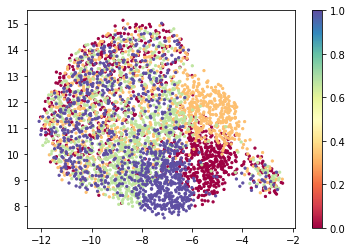

In [ ]:
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

adata = create_adata(generation.cpu().detach().numpy(), label)
adata = umap(adata, True, 10)
plt.scatter(adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1], cmap='Spectral', norm=norm, c=np.array(label).astype(np.float32)/3, s=5, alpha=1)
plt.colorbar()

In [ ]:
RNA_1, RNA_decoder_1, RNA_generation_1, rna_embd_1, rna_embd_prior_1 = generate(30, 1000)
RNA_2, RNA_decoder_2, RNA_generation_2, rna_embd_2, rna_embd_prior_2 = generate(80, 1000)

RNA = torch.cat((RNA_1, RNA_2), 0).cpu().detach().numpy()
RNA_decoder = torch.cat((RNA_decoder_1, RNA_decoder_2), 0).cpu().detach().numpy()
RNA_generation = torch.cat((RNA_generation_1, RNA_generation_2), 0).cpu().detach().numpy()

rna_embd = torch.cat((rna_embd_1, rna_embd_2), 0).cpu().detach().numpy()
rna_embd_prior = torch.cat((rna_embd_prior_1, rna_embd_prior_2), 0).cpu().detach().numpy()

len1 = rna_embd_prior_1.shape[0]
len2 = rna_embd_prior_2.shape[0]

label1 = [0]*len1
label1.extend([1]*len2)

len1 = rna_embd_1.shape[0]
len2 = rna_embd_2.shape[0]

label2 = [0]*len1
label2.extend([1]*len2)


# generation = real
# generation = embedding


In [ ]:
RNA_all = np.concatenate((RNA, RNA_generation), 0)
label_all = label2.copy()
label_all.extend([l+2 for l in label1])

norm = matplotlib.colors.Normalize(vmin=0, vmax=3)

adata = create_adata(RNA_all, label_all)
adata = umap(adata, True, 100)
plt.scatter(adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1], cmap='Spectral', norm=norm, c=np.array(label_all).astype(np.float32), s=2, alpha=0.2)
plt.colorbar()

In [ ]:
import numpy as np
from scipy import sparse
import scanpy 
import pandas as pd


def create_adata(generation, label):
  category = {}
  for (i, prot) in enumerate(label):
      category[str(i)] = prot
  adata = scanpy.AnnData(generation)
  a = pd.Series(category, dtype='category')
  adata.obs['category'] = np.array(label).astype(np.float32)

  return adata

def umap(adata, normalize, n_neighbors):
    if normalize == True:
        scanpy.pp.normalize_total(adata, target_sum=1e3)
        scanpy.pp.log1p(adata)
    scanpy.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=0)
    scanpy.tl.umap(adata)

    return adata

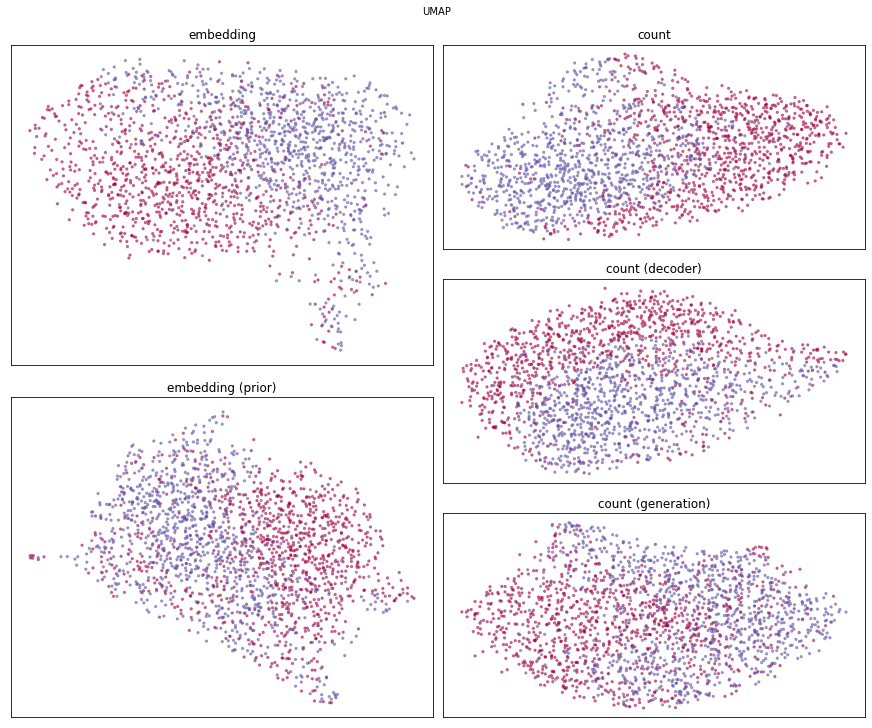

In [ ]:
import matplotlib
import scanpy

def umap(adata, normalize, n_neighbors):
    if normalize == True:
        scanpy.pp.normalize_total(adata, target_sum=1e3)
        scanpy.pp.log1p(adata)
    scanpy.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=0)
    scanpy.tl.umap(adata)

    return adata


norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

fig = plt.figure(constrained_layout=True, figsize=(12, 10))
gs0 = fig.add_gridspec(1, 2)

gs00 = gs0[0].subgridspec(2, 1)
gs01 = gs0[1].subgridspec(3, 1)

for a in range(2):
    ax = fig.add_subplot(gs00[a])
    if a == 0:
      adata = create_adata(rna_embd, label2)
      adata = umap(adata, False, 10)
      ax.scatter(adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1], cmap='Spectral', norm=norm, c=np.array(label2).astype(np.float32), s=5, alpha=0.5)
      ax.title.set_text('embedding') 
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      adata = create_adata(rna_embd_prior, label1)
      adata = umap(adata, False, 10)
      ax.scatter(adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1], cmap='Spectral', norm=norm, c=np.array(label1).astype(np.float32), s=5, alpha=0.5)
      ax.title.set_text('embedding (prior)')
      ax.set_xticks([])
      ax.set_yticks([])
        
for a in range(3):
    ax = fig.add_subplot(gs01[a])
    if a == 0:
      adata = create_adata(RNA, label2)
      adata = umap(adata, True, 10)
      ax.scatter(adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1], cmap='Spectral', norm=norm, c=np.array(label2).astype(np.float32), s=5, alpha=0.5)
      ax.title.set_text('count')
      ax.set_xticks([])
      ax.set_yticks([])
    elif a == 1:
      adata = create_adata(RNA_decoder, label2)
      adata = umap(adata, True, 10)
      ax.scatter(adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1], cmap='Spectral', norm=norm, c=np.array(label2).astype(np.float32), s=5, alpha=0.5)
      ax.title.set_text('count (decoder)')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      adata = create_adata(RNA_generation, label1)
      adata = umap(adata, True, 10)
      ax.scatter(adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1], cmap='Spectral', norm=norm, c=np.array(label1).astype(np.float32), s=5, alpha=0.5)
      ax.title.set_text('count (generation)') 
      ax.set_xticks([])
      ax.set_yticks([])

fig.suptitle('UMAP', fontsize=10)
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
# position = fig.add_axes([0.92, 0.12, 0.015, .78 ])
# fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='Spectral'))